In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import dask.dataframe as dd
#from ydata_profiling import ProfileReport
#%matplotlib inline
#/home/dorra/.local/bin/streamlit run main.py

In [2]:

df_InfoUser  = pd.read_csv(r'/media/dorra/62207C0F207BE885/Users/ASUS/Desktop/archive/Info_UserData.csv',nrows=5000)
df_LogProblem = dd.read_csv(r'/media/dorra/62207C0F207BE885/Users/ASUS/Desktop/archive/Log_Problem.csv')
df_InfoContent = pd.read_csv(r'/media/dorra/62207C0F207BE885/Users/ASUS/Desktop/archive/Info_Content.csv')

In [3]:
print(f"the shape of df_InfoUser is: {df_InfoUser.shape}")
rows=df_LogProblem.shape[0].compute()
columns=df_LogProblem.shape[1]
print("the shape of df_LogProblem is: (", rows,"," ,columns,")")
print(f"the shape of df_InfoContent is: {df_InfoContent.shape}")

the shape of df_InfoUser is: (5000, 12)


the shape of df_LogProblem is: ( 16217311 , 14 )
the shape of df_InfoContent is: (1330, 10)


# Data Cleaning

In [4]:
unique_uuids_in_infouser = df_InfoUser['uuid'].unique()

unique_ucids_in_logproblem = df_LogProblem['ucid'].unique().compute()

df_LogProblem = df_LogProblem[df_LogProblem['uuid'].isin(unique_uuids_in_infouser)]

df_InfoContent= df_InfoContent[df_InfoContent['ucid'].isin(unique_ucids_in_logproblem)]

rows=df_LogProblem.shape[0].compute()
columns=df_LogProblem.shape[1]
print(f"The shape of df_InfoUser is: {df_InfoUser.shape}")
print("The shape of df_LogProblem is: (", rows,"," ,columns,")")
print(f"The shape of df_InfoContent is: {df_InfoContent.shape}")

unique=df_LogProblem['uuid'].unique().compute()
print(len(unique))



The shape of df_InfoUser is: (5000, 12)
The shape of df_LogProblem is: ( 998040 , 14 )
The shape of df_InfoContent is: (1326, 10)
5000


In [5]:
df_LogProblem=df_LogProblem.compute()

In [6]:
print(df_LogProblem.shape)

(998040, 14)


## 1_Check for missing values:

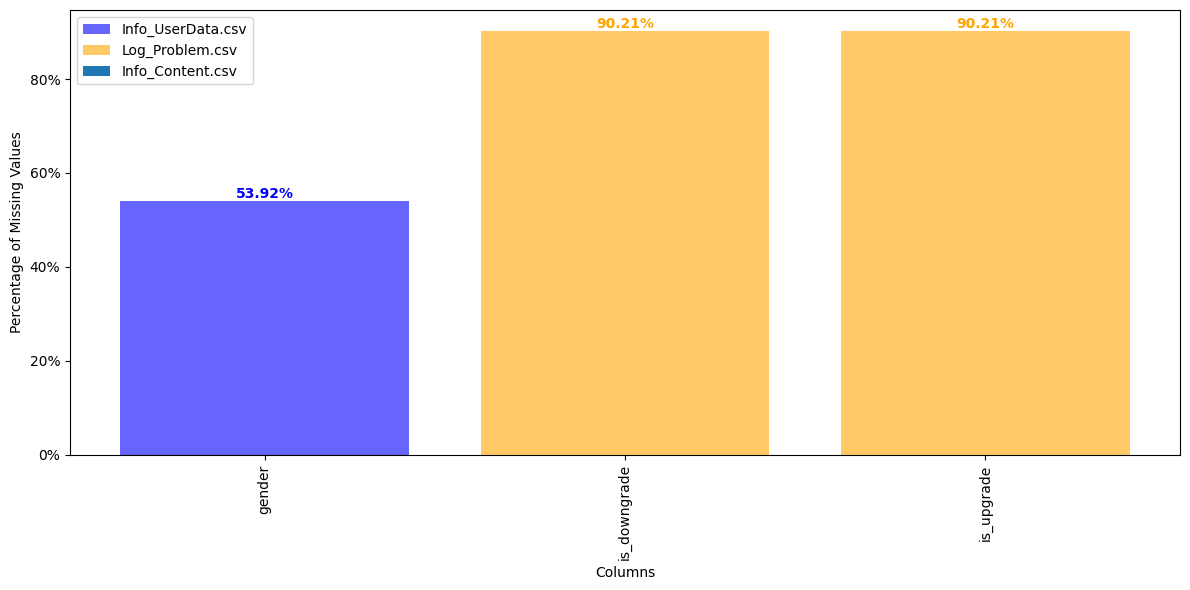

In [7]:

missing_values_InfoUser = df_InfoUser.isnull().sum()
missing_values_LogProblem = df_LogProblem.isnull().sum()
missing_values_InfoContent = df_InfoContent.isnull().sum()


total_rows_InfoUser = len(df_InfoUser)
total_rows_LogProblem = len(df_LogProblem)
total_rows_InfoContent = len(df_InfoContent)

percentage_missing_InfoUser = (missing_values_InfoUser / total_rows_InfoUser) * 100
percentage_missing_LogProblem = (missing_values_LogProblem / total_rows_LogProblem) * 100
percentage_missing_InfoContent = (missing_values_InfoContent / total_rows_InfoContent) * 100

filtered_missing_InfoUser = percentage_missing_InfoUser[percentage_missing_InfoUser > 1]
filtered_missing_LogProblem = percentage_missing_LogProblem[percentage_missing_LogProblem > 1]
filtered_missing_InfoContent = percentage_missing_InfoContent[percentage_missing_InfoContent > 1]

plt.figure(figsize=(12, 6))
plt.bar(filtered_missing_InfoUser.index, filtered_missing_InfoUser, label='Info_UserData.csv', color='blue', alpha=0.6)
plt.bar(filtered_missing_LogProblem.index, filtered_missing_LogProblem, label='Log_Problem.csv', color='orange', alpha=0.6)
plt.bar(filtered_missing_InfoContent.index, filtered_missing_InfoContent, label='Info_Content.csv', color='green', alpha=0.6)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

for i, v in enumerate(filtered_missing_InfoUser):
    plt.text(i, v, f"{v:.2f}%", ha='center', va='bottom', color='blue', fontweight='bold')

for i, v in enumerate(filtered_missing_LogProblem):
    plt.text(i + len(filtered_missing_InfoUser), v, f"{v:.2f}%", ha='center', va='bottom', color='orange', fontweight='bold')

for i, v in enumerate(filtered_missing_InfoContent):
    plt.text(i + len(filtered_missing_InfoUser) + len(filtered_missing_LogProblem), v, f"{v:.2f}%", ha='center', va='bottom', color='green', fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

INSIGHTS:
Impact on Recommendation Systems->remove Data [is_downgrade, is_upgrade]

## 2_Check for outliers:

In [8]:
#InfoUser

users_with_zero_teachers_and_students = df_InfoUser[(df_InfoUser['has_teacher_cnt'] == 0) & (df_InfoUser['has_student_cnt'] == 0)]

not_self_coach =  users_with_zero_teachers_and_students[(users_with_zero_teachers_and_students['is_self_coach']== False)]

num_not_self_coach = len(not_self_coach)

print("users with 0 students, 0 teachers and not self coach:",num_not_self_coach)

total_users = len(df_InfoUser)

num_not_self_coach = len(not_self_coach)

percentage_not_self_coach = (num_not_self_coach / total_users) * 100

percentage_other_users = 100 - percentage_not_self_coach

labels = ['0 students, 0 teachers, and not self-coach', 'Other users']
values = [percentage_not_self_coach, percentage_other_users]
layout = go.Layout(title="Percentage of Users with 0 students, 0 teachers, and not self-coach")

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)], layout=layout)

fig.show()


users with 0 students, 0 teachers and not self coach: 1585


INSIGHTS:
Users with grade or point > 0 are to be considered as Students
Propositions:
1-Regression imputation
2-Mean imputation

In [9]:
#LogProblem
df_zero_sec_taken = df_LogProblem[df_LogProblem['total_sec_taken'] == 0]

num_users_with_zero_sec_taken = df_zero_sec_taken['uuid'].nunique()

print("Number of users with 0 seconds taken:", num_users_with_zero_sec_taken)

Number of users with 0 seconds taken: 1517


INSIGHTS:

1_Users with 0 'total_sec_taken': Users with a total_sec_taken of 0 likely indicate instances where the users did not spend any time attempting the problem. Insights from these cases might include:

   .Users who accessed the problem but did not engage in any interaction, possibly indicating a lack of interest or motivation.
   .Users who navigated to the problem but left the platform or session before attempting it.

Possible actions or improvements could include:

  Identifying potential usability issues or design flaws in the platform that might discourage users from attempting or interacting with problems.

  Providing additional guidance or incentives to encourage users to actively attempt more problems and engage in learning activities.

# The distribution of students across different learning stages:

In [10]:
learning_stages_count = df_InfoContent['learning_stage'].value_counts()
total_students = len(df_InfoContent)

percentage_per_stage = (learning_stages_count / total_students) * 100

fig = go.Figure(data=[go.Bar(x=learning_stages_count.index, y=learning_stages_count.values)])

for i in range(len(learning_stages_count)):
    value_count = learning_stages_count.values[i]
    percentage = percentage_per_stage.values[i]
    text = f"{value_count} ({percentage:.2f}%)"
    fig.add_annotation(
        x=learning_stages_count.index[i],
        y=learning_stages_count.values[i],
        text=text,
        showarrow=True,
        arrowhead=1
    )

fig.update_layout(
    title='Distribution of Students Across Learning Stages',
    xaxis_title='Learning Stage',
    yaxis_title='Number of Students',
    showlegend=False
)

fig.show()


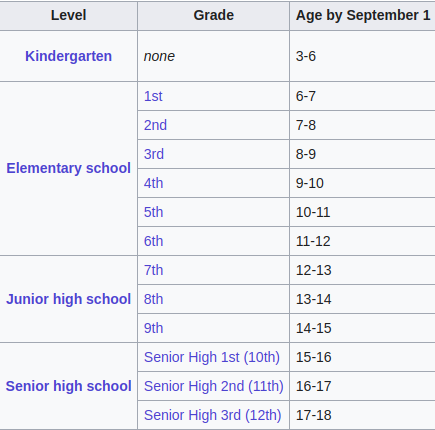

In [11]:
from IPython.display import Image

image_path = '/home/dorra/Pictures/3.png'

Image(filename=image_path)


# The distribution of difficulties of the exercises:

In [12]:
import plotly.graph_objects as go

difficulty_distribution = df_InfoContent['difficulty'].value_counts()

colors = ['blue', 'green', 'orange', 'red']

fig = go.Figure(data=[go.Pie(labels=difficulty_distribution.index, values=difficulty_distribution.values, marker=dict(colors=colors))])

fig.update_layout(title='Distribution of Difficulties of Exercises')

fig.show()


# The number of students who have attempted to answer the problems in the exercises:

In [13]:
unique_students_attempted = df_LogProblem['uuid'].nunique()
print(unique_students_attempted)


5000


#  The average number of problems in a single exercise:

In [14]:
exercise_problem_counts = df_LogProblem.groupby('ucid')['problem_number'].nunique()

average_problems_per_exercise = int(exercise_problem_counts.mean())

print("Average number of problems in a single exercise:", average_problems_per_exercise)

print("Total Number of Exercises:", len(df_InfoContent['ucid']))


Average number of problems in a single exercise: 47
Total Number of Exercises: 1326


#  The average number of hints used per student per exercise:

In [15]:
average_hints_per_student_per_exercise = int(df_LogProblem.groupby(['uuid', 'ucid'])['used_hint_cnt'].size().mean())

print("Average number of hints used per student per exercise:", average_hints_per_student_per_exercise)


Average number of hints used per student per exercise: 9


#  The average number of attempts per student per exercise:

In [16]:
average_attempts_per_student = int(df_LogProblem.groupby(['uuid', 'ucid'])['total_attempt_cnt'].size().mean())
print("Average number of attempts per student per exercise: ",average_attempts_per_student)


Average number of attempts per student per exercise:  9
